In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import numpy as np

In [2]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    report = classification_report(labels, predictions, output_dict=True)
    return {
        'accuracy': report['accuracy'],
        'macro avg': report['macro avg']['f1-score'],
        'weighted avg': report['weighted avg']['f1-score']
    }

In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Step 1: Load Dataset
data = pd.read_csv('/kaggle/input/informations/balanced_data_with_features.csv')

# Step 2: Train-Test Split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Step 3: Prepare Dataset for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_data['url'].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_data['url'].tolist(), truncation=True, padding=True, max_length=128)

train_labels = train_data['label'].values
test_labels = test_data['label'].values

# Step 4: Define PyTorch Dataset
class URLDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = URLDataset(train_encodings, train_labels)
test_dataset = URLDataset(test_encodings, test_labels)

# Step 5: Load Pretrained DistilBERT Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(set(train_labels))).to('cuda')

# Step 6: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy='epoch',
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True
)

# Step 7: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Step 8: Train and Evaluate Model
trainer.train()
trainer.evaluate()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.wa

Epoch,Training Loss,Validation Loss,Accuracy,Macro avg,Weighted avg
1,0.289700,0.297081,0.804523,0.792426,0.769799
2,0.209000,0.292457,0.804426,0.772540,0.757107
3,0.253100,0.302280,0.804707,0.772906,0.757471


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.2924574315547943,
 'eval_accuracy': 0.804425500514593,
 'eval_macro avg': 0.7725400170374068,
 'eval_weighted avg': 0.7571065330965792,
 'eval_runtime': 253.9115,
 'eval_samples_per_second': 405.629,
 'eval_steps_per_second': 12.678,
 'epoch': 3.0}

In [4]:
# Step 9: Save the Fine-Tuned Model
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

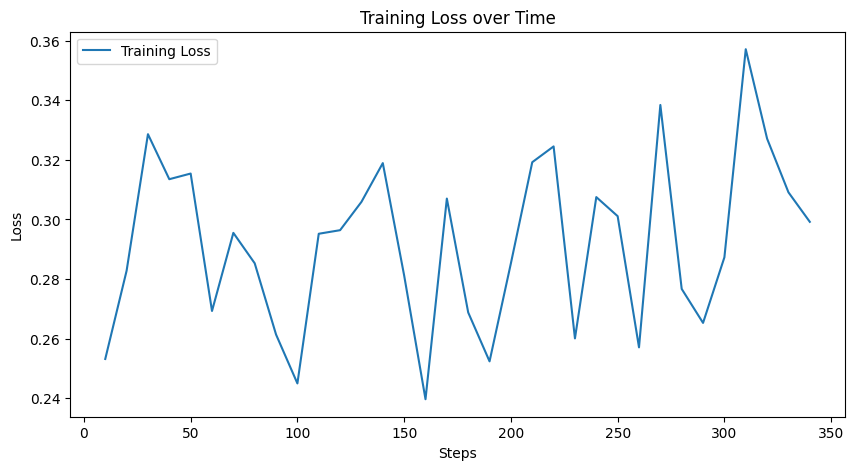

In [6]:
import matplotlib.pyplot as plt

# Extract log history from the trainer
logs = trainer.state.log_history

# Separate Training and Evaluation Logs
train_logs = [log for log in logs if 'loss' in log.keys() and 'eval_loss' not in log.keys()]
eval_logs = [log for log in logs if 'eval_loss' in log.keys()]

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot([log['step'] for log in train_logs], [log['loss'] for log in train_logs], label='Training Loss')
plt.title('Training Loss over Time')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Evaluation Loss
if eval_logs:
    plt.figure(figsize=(10, 5))
    plt.plot([log['step'] for log in eval_logs], [log['eval_loss'] for log in eval_logs], label='Evaluation Loss', color='red')
    plt.title('Evaluation Loss over Time')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
!zip -r /kaggle/working/results.zip /kaggle/working/results

  adding: kaggle/working/results/ (stored 0%)
  adding: kaggle/working/results/checkpoint-12875/ (stored 0%)
  adding: kaggle/working/results/checkpoint-12875/optimizer.pt (deflated 21%)
  adding: kaggle/working/results/checkpoint-12875/trainer_state.json (deflated 84%)
  adding: kaggle/working/results/checkpoint-12875/config.json (deflated 51%)
  adding: kaggle/working/results/checkpoint-12875/rng_state.pth (deflated 25%)
  adding: kaggle/working/results/checkpoint-12875/training_args.bin (deflated 52%)
  adding: kaggle/working/results/checkpoint-12875/scheduler.pt (deflated 55%)
  adding: kaggle/working/results/checkpoint-12875/model.safetensors (deflated 8%)
  adding: kaggle/working/results/checkpoint-25750/ (stored 0%)
  adding: kaggle/working/results/checkpoint-25750/optimizer.pt (deflated 21%)
  adding: kaggle/working/results/checkpoint-25750/trainer_state.json (deflated 84%)
  adding: kaggle/working/results/checkpoint-25750/config.json (deflated 51%)
  adding: kaggle/working/res